# 共通部分

In [2]:
#############################
# モジュールのインポート
#############################

import os
import random

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
from tensorflow.python.ops import nn
from tensorflow.python.ops import math_ops
from tensorflow.python.keras import initializers
from tensorflow.python.ops import variables as tf_variables
from tensorflow.python.framework import ops
from tensorflow.python.keras import backend


#############################
# 定数の定義
#############################

EPOCHS = 15
BATCH_SIZE = 32
SEED = 42
TRAIN_DATA_SIZE = 60000
TEST_DATA_SIZE = 10000 


#############################
# モデルの定義
#############################

class BaseModel(Model):
    def __init__(self, NormalizationLayer):
        super(BaseModel, self).__init__()
        self.conv1 = Conv2D(128, kernel_size=(3, 3), activation='relu')
        self.norm1 = NormalizationLayer()
        self.conv2 = Conv2D(64, kernel_size=(3, 3), activation='relu')
        self.norm2 = NormalizationLayer()
        self.flatten = Flatten()
        self.d1 = Dense(128, activation='relu')
        self.d2 = Dense(10, activation='softmax')

    def call(self, x, training=None):
        x = self.conv1(x)
        x = self.norm1(x, training)
        x = self.conv2(x)
        x = self.norm2(x, training)
        x = self.flatten(x)
        x = self.d1(x)
        return self.d2(x)


#############################
# 学習のメインループ
#############################

def main(model):

    # シードの固定
    tf.random.set_seed(SEED)
    np.random.seed(SEED)
    random.seed(SEED)
    os.environ["PYTHONHASHSEED"] = str(SEED)

    ##############################

    # MNISTデータの取得
    mnist = tf.keras.datasets.mnist
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = tf.cast(x_train, tf.float32)
    x_test = tf.cast(x_test, tf.float32)

    x_train, y_train = x_train[:TRAIN_DATA_SIZE], y_train[:TRAIN_DATA_SIZE]
    x_test, y_test = x_test[:TEST_DATA_SIZE], y_test[:TEST_DATA_SIZE]

    x_train, x_test = x_train / 255.0, x_test / 255.0

    x_train = x_train[..., tf.newaxis]
    x_test = x_test[..., tf.newaxis]

    train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(10000).batch(BATCH_SIZE)

    test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)

    ##############################
    
    # 訓練関数、損失、オプティマイザなどの定義

    loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
    optimizer = tf.keras.optimizers.Adam()

    train_loss = tf.keras.metrics.Mean(name='train_loss')
    train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

    test_loss = tf.keras.metrics.Mean(name='test_loss')
    test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

    def train_step(model, images, labels):
        with tf.GradientTape() as tape:
            predictions = model(images, training=True)
            loss = loss_object(labels, predictions)

        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        train_loss(loss)
        train_accuracy(labels, predictions)

    def test_step(model, images, labels):
        predictions = model(images, training=False)
        t_loss = loss_object(labels, predictions)

        test_loss(t_loss)
        test_accuracy(labels, predictions)

    ##############################

    # 学習

    result_train_loss = np.zeros(EPOCHS)
    result_train_accuracy = np.zeros(EPOCHS)
    result_test_loss = np.zeros(EPOCHS)
    result_test_accuracy = np.zeros(EPOCHS)

    for epoch in range(EPOCHS):

        print(f'---Epoch: {epoch+1}---')

        # 訓練
        for images, labels in train_ds:
            train_step(model, images, labels)

        result_train_loss[epoch] = train_loss.result()
        result_train_accuracy[epoch] = train_accuracy.result()
        log_txt = f'{"[train]":<10} Loss: {train_loss.result()}, Accuracy: {train_accuracy.result()*100}'
        print(log_txt)

        # テスト
        for test_images, test_labels in test_ds:
            test_step(model, test_images, test_labels)

        result_test_loss[epoch] = test_loss.result()
        result_test_accuracy[epoch] = test_accuracy.result()
        log_txt = f'{"[test]":<10} Loss: {test_loss.result()}, Accuracy: {test_accuracy.result()*100}'
        print(log_txt)

        # 損失などの初期化
        train_loss.reset_states()
        train_accuracy.reset_states()
        test_loss.reset_states()
        test_accuracy.reset_states()

    ##############################

    # 描画
    x = np.arange(1, EPOCHS + 1)

    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111)
    ax.plot(x, result_train_loss, label="train_loss")
    ax.plot(x, result_test_loss, label="test_loss")
    plt.legend()
    plt.show()

    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111)
    ax.plot(x, result_train_accuracy, label="train_accuracy")
    ax.plot(x, result_test_accuracy, label="test_accuracy")
    plt.legend()
    plt.show()

# バッチ正規化

---Epoch: 1---
[train]    Loss: 0.19676871597766876, Accuracy: 95.3616714477539
[test]     Loss: 0.1302090734243393, Accuracy: 96.37000274658203
---Epoch: 2---
[train]    Loss: 0.06838078051805496, Accuracy: 98.10166931152344
[test]     Loss: 0.06792304664850235, Accuracy: 98.1199951171875
---Epoch: 3---
[train]    Loss: 0.04995107650756836, Accuracy: 98.62833404541016
[test]     Loss: 0.08285734802484512, Accuracy: 98.05999755859375
---Epoch: 4---
[train]    Loss: 0.028797753155231476, Accuracy: 99.15666198730469
[test]     Loss: 0.12674085795879364, Accuracy: 97.23999786376953
---Epoch: 5---
[train]    Loss: 0.022465625777840614, Accuracy: 99.29166412353516
[test]     Loss: 0.08830833435058594, Accuracy: 98.25
---Epoch: 6---
[train]    Loss: 0.017918836325407028, Accuracy: 99.47333526611328
[test]     Loss: 0.0729295164346695, Accuracy: 98.62999725341797
---Epoch: 7---
[train]    Loss: 0.014561781659722328, Accuracy: 99.58333587646484
[test]     Loss: 0.07107402384281158, Accuracy: 9

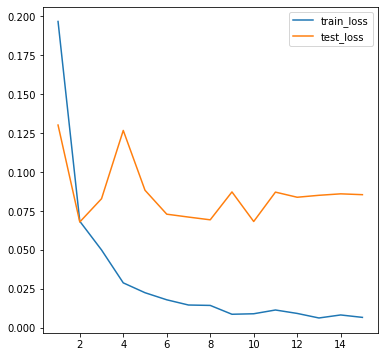

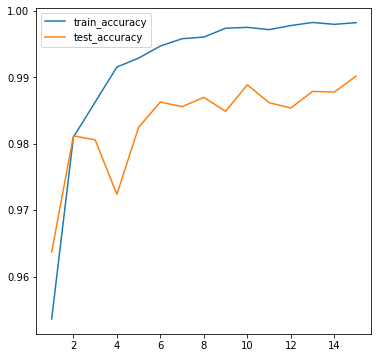

In [5]:
################################
# バッチ正規化
################################

class BatchNormalization(tf.keras.layers.Layer):

    def __init__(self, momentum=0.99, epsilon=1e-7):
        super().__init__()
        self.momentum = tf.constant(momentum)
        self.epsilon = tf.constant(epsilon)

    def build(self, input_shape):

        ### 穴埋めポイント ###
        weight_shape = [1] * len(input_shape)
        weight_shape[-1] = input_shape[-1]

        self.gamma = self.add_weight(
            name='gamma',
            shape=weight_shape,
            initializer=initializers.get('ones'),
            trainable=True,
            experimental_autocast=False)

        self.beta = self.add_weight(
            name='beta',
            shape=weight_shape,
            initializer=initializers.get('zeros'),
            trainable=True,
            experimental_autocast=False)

        self.moving_mean = self.add_weight(
            name='moving_mean',
            shape=weight_shape,
            initializer=initializers.get('zeros'),
            synchronization=tf_variables.VariableSynchronization.ON_READ,
            trainable=False,
            aggregation=tf_variables.VariableAggregation.MEAN,
            experimental_autocast=False)

        self.moving_variance = self.add_weight(
            name='moving_variance',
            shape=weight_shape,
            initializer=initializers.get('ones'),
            synchronization=tf_variables.VariableSynchronization.ON_READ,
            trainable=False,
            aggregation=tf_variables.VariableAggregation.MEAN,
            experimental_autocast=False)

        self.built = True

    def _assign_new_value(self, variable, value):
        with backend.name_scope('AssignNewValue') as scope:
            if ops.executing_eagerly_outside_functions():
                return variable.assign(value, name=scope)
            else:
                with ops._colocate_with(variable):
                    return state_ops.assign(variable, value, name=scope)

    def call(self, x, training=None):

        ### 穴埋めポイント ###
        if training:
            mean, variance = tf.nn.moments(x, [i for i in range(len(x.shape) - 1)], keepdims=True)
            x_std = (x - mean) / math_ops.sqrt(variance + self.epsilon)
            moving_mean = self.momentum * self.moving_mean + (tf.constant(1.0) - self.momentum) * mean
            moving_variance = self.momentum * self.moving_variance + (tf.constant(1.0) - self.momentum) * variance
            self._assign_new_value(self.moving_mean, moving_mean)
            self._assign_new_value(self.moving_variance, moving_variance)
        else:
            x_std = (x - self.moving_mean) / math_ops.sqrt(self.moving_variance + self.epsilon)

        ret = self.gamma * x_std + self.beta
        return ret


#############################
# 実行
#############################
model = BaseModel(BatchNormalization)
main(model)

# レイヤー正規化

---Epoch: 1---
[train]    Loss: 0.1896957904100418, Accuracy: 94.9383316040039
[test]     Loss: 0.1086474061012268, Accuracy: 96.9000015258789
---Epoch: 2---
[train]    Loss: 0.060567114502191544, Accuracy: 98.22833251953125
[test]     Loss: 0.05933869630098343, Accuracy: 98.16999816894531
---Epoch: 3---
[train]    Loss: 0.03910517320036888, Accuracy: 98.80166625976562
[test]     Loss: 0.052905403077602386, Accuracy: 98.43999481201172
---Epoch: 4---
[train]    Loss: 0.02515411376953125, Accuracy: 99.17166900634766
[test]     Loss: 0.06340551376342773, Accuracy: 98.3699951171875
---Epoch: 5---
[train]    Loss: 0.018703309819102287, Accuracy: 99.35832977294922
[test]     Loss: 0.04097845405340195, Accuracy: 98.72999572753906
---Epoch: 6---
[train]    Loss: 0.012829046696424484, Accuracy: 99.58666229248047
[test]     Loss: 0.04672342911362648, Accuracy: 98.6199951171875
---Epoch: 7---
[train]    Loss: 0.009962441399693489, Accuracy: 99.66999816894531
[test]     Loss: 0.05329553782939911, 

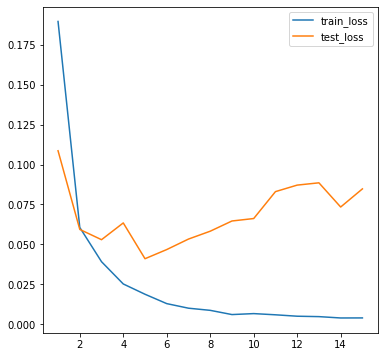

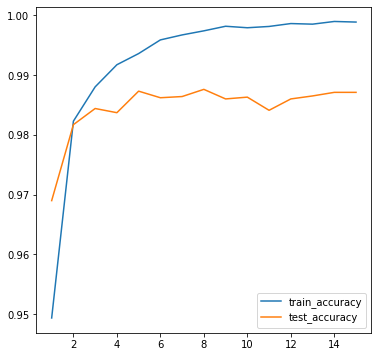

In [6]:
class LayerNormalization(tf.keras.layers.Layer):

    def __init__(self, momentum=0.99, epsilon=1e-7):
        super().__init__()
        self.momentum = tf.constant(momentum)
        self.epsilon = tf.constant(epsilon)

    def build(self, input_shape):

        ### 穴埋めポイント ###
        weight_shape = 1

        self.gamma = self.add_weight(
            name='gamma',
            shape=weight_shape,
            initializer=initializers.get('ones'),
            trainable=True,
            experimental_autocast=False)

        self.beta = self.add_weight(
            name='beta',
            shape=weight_shape,
            initializer=initializers.get('zeros'),
            trainable=True,
            experimental_autocast=False)

        self.built = True

    def call(self, x, training=None):

        ### 穴埋めポイント ###
        mean, variance = tf.nn.moments(x, [i for i in range(1, len(x.shape))], keepdims=True)
        x_std = (x - mean) / math_ops.sqrt(variance + self.epsilon)
        ret = self.gamma * x_std + self.beta
        return ret

#############################
# 実行
#############################
model = BaseModel(LayerNormalization)
main(model)

# インスタンス正規化

11493376/11490434 [==============================] - 0s 0us/step
---Epoch: 1---
[train]    Loss: 0.2042340636253357, Accuracy: 95.17166900634766
[test]     Loss: 0.08429078757762909, Accuracy: 97.56999969482422
---Epoch: 2---
[train]    Loss: 0.06951650977134705, Accuracy: 98.17666625976562
[test]     Loss: 0.08127496391534805, Accuracy: 98.05999755859375
---Epoch: 3---
[train]    Loss: 0.04728802666068077, Accuracy: 98.66999816894531
[test]     Loss: 0.07336469739675522, Accuracy: 98.04000091552734
---Epoch: 4---
[train]    Loss: 0.03548715263605118, Accuracy: 99.0183334350586
[test]     Loss: 0.06996564567089081, Accuracy: 98.30999755859375
---Epoch: 5---
[train]    Loss: 0.025532135739922523, Accuracy: 99.26333618164062
[test]     Loss: 0.05839116871356964, Accuracy: 98.72999572753906
---Epoch: 6---
[train]    Loss: 0.01841399073600769, Accuracy: 99.49333190917969
[test]     Loss: 0.07768870145082474, Accuracy: 98.54000091552734
---Epoch: 7---
[train]    Loss: 0.015125821344554424, 

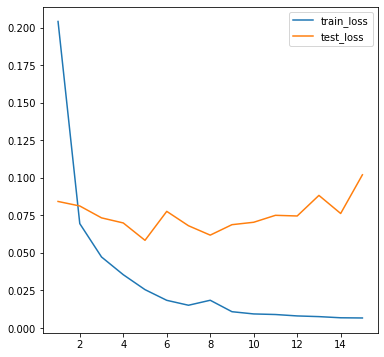

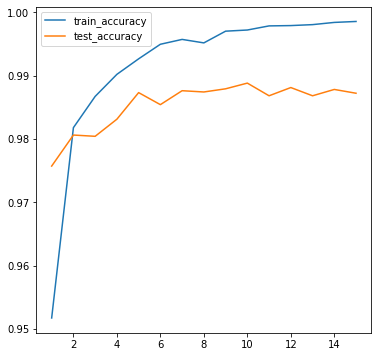

In [3]:
class InstanceNormalization(tf.keras.layers.Layer):

    def __init__(self, momentum=0.99, epsilon=1e-7):
        super().__init__()
        self.momentum = tf.constant(momentum)
        self.epsilon = tf.constant(epsilon)

    def build(self, input_shape):

        ### 穴埋めポイント ###
        weight_shape = [1] * len(input_shape)
        weight_shape[-1] = input_shape[-1]

        self.gamma = self.add_weight(
            name='gamma',
            shape=weight_shape,
            initializer=initializers.get('ones'),
            trainable=True,
            experimental_autocast=False)

        self.beta = self.add_weight(
            name='beta',
            shape=weight_shape,
            initializer=initializers.get('zeros'),
            trainable=True,
            experimental_autocast=False)

        self.built = True

    def call(self, x, training=None):

        ### 穴埋めポイント ###
        mean, variance = tf.nn.moments(x, [i for i in range(1, len(x.shape) - 1)], keepdims=True)
        x_std = (x - mean) / math_ops.sqrt(variance + self.epsilon)
        ret = self.gamma * x_std + self.beta

        return ret


#############################
# 実行
#############################
model = BaseModel(InstanceNormalization)
main(model)

# 正規化なしモデル

---Epoch: 1---
[train]    Loss: 0.10644256323575974, Accuracy: 96.70333099365234
[test]     Loss: 0.06184527277946472, Accuracy: 98.18999481201172
---Epoch: 2---
[train]    Loss: 0.03533490374684334, Accuracy: 98.89666748046875
[test]     Loss: 0.03997994214296341, Accuracy: 98.75
---Epoch: 3---
[train]    Loss: 0.019795002415776253, Accuracy: 99.36666870117188
[test]     Loss: 0.04337068274617195, Accuracy: 98.68999481201172
---Epoch: 4---
[train]    Loss: 0.012222236022353172, Accuracy: 99.62333679199219
[test]     Loss: 0.05110679566860199, Accuracy: 98.68000030517578
---Epoch: 5---
[train]    Loss: 0.009648419916629791, Accuracy: 99.69666290283203
[test]     Loss: 0.05502578988671303, Accuracy: 98.72000122070312
---Epoch: 6---
[train]    Loss: 0.008861294947564602, Accuracy: 99.70500183105469
[test]     Loss: 0.05958014726638794, Accuracy: 98.75
---Epoch: 7---
[train]    Loss: 0.006462389137595892, Accuracy: 99.8066635131836
[test]     Loss: 0.05624877288937569, Accuracy: 98.819999

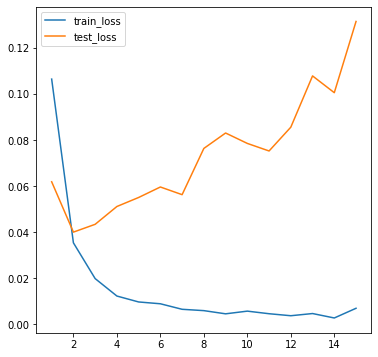

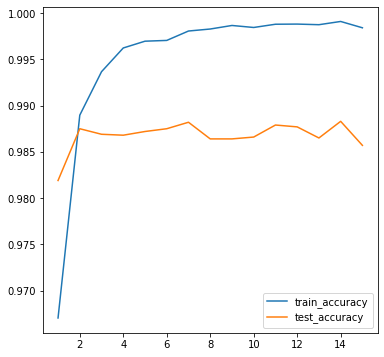

In [5]:
class BaseModel(Model):
    def __init__(self):
        super(BaseModel, self).__init__()
        self.conv1 = Conv2D(128, kernel_size=(3, 3), activation='relu')
        self.conv2 = Conv2D(64, kernel_size=(3, 3), activation='relu')
        self.flatten = Flatten()
        self.d1 = Dense(128, activation='relu')
        self.d2 = Dense(10, activation='softmax')

    def call(self, x, training=None):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.flatten(x)
        x = self.d1(x)
        return self.d2(x)

#############################
# 実行
#############################
model = BaseModel()
main(model)